# Global Overturning Streamfunction

This scipt plots the global overturning streamfunction in density space for 3 ACCESS-OM2 simulations at different resolutions.

It also serves as a sample for how to compute and display diagnostics for the ACCESS-OM2 model evaluation paper.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

from dask.distributed import Client

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* This version was run in an 8-cpu expressbw job with 128Gb RAM, running on raijin.
* In a terminal, run: `dask-scheduler`
* This should output the scheduler address, like `tcp://10.9.69.70:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.9.69.70:8786 --memory-limit 16e9 --nprocs 6 --nthreads 1`
* Then, make sure the following cell matches the scheduler address.

In [3]:
client = Client('tcp://10.9.69.70:8786')
client

Client Scheduler: tcp://10.9.69.70:8786 Dashboard: http://10.9.69.70:8787/status,Cluster Workers: 6 Cores: 6 Memory: 96.00 GB


**For starters**, list the three experiments you want to use. For now, we will use RYF sample runs - in the future we hope to be using the full interannual forcing simulations. This script assumes that there are 3 experiments, and that they are ordered as 1°, 0.25° then 0.1°.

This function computes the overturning from ty_trans_rho (and ty_trans_rho_gm if the variable is present). It loads data from the last IAF cycle (specified as n_files in exptdata) and then averages over the default period (1993-2017 inc.).

In [4]:
def calc_psi_avg(ekey):
    
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    ## Load overturning from ocean.nc file
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=n_files,
                          time_units=time_units, offset=offset)
    psi = psi.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time').sum('grid_xt_ocean')*1.0e-9
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=n_files,
                              time_units=time_units, offset=offset)
        psiGM = psiGM.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time').sum('grid_xt_ocean')*1.0e-9
    else:
        GM = False
        
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    if GM:
        psi_avg = psi_avg + psiGM
    
    ## This function basically splits the calculation up to save on memory:
    #psi_avg = cc.compute_by_block(psi_avg)
    psi_avg = psi_avg.load()
    
    return psi_avg

This function plots the streamfunction.

In [5]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    dens0=1020
    y_axis = (psi_avg.potrho-dens0)**9
    #np.exp((psi_avg.potrho-dens0))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 y_axis, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                y_axis, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                y_axis, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    ticklabels = [1037.25, 1037, 1036.5, 1036, 1035, 1034, 1033, 1030]
    ticks = (np.array(ticklabels)-dens0)**9 #np.exp(ticklabels-dens0)
    plt.ylim((1037.25-dens0)**9)#(np.exp(1037.3-dens0),0))
    plt.yticks(ticks)
    plt.gca().set_yticklabels(ticklabels)
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

And here is the code to make the actual figure.

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


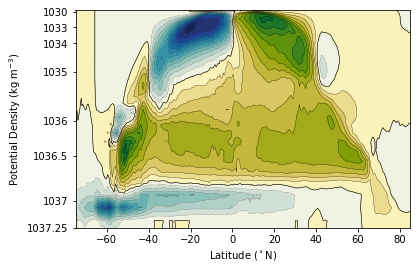

In [6]:
# for testing
clev=np.arange(-26,26.01,2)
ekey = '1deg'
psi_avg = calc_psi_avg(ekey)
p1=plot_psi(psi_avg,clev)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Bbox(x0=0.31, y0=0.1250000000000001, x1=0.6918181818181819, y1=0.46818181818181825)
CPU times: user 37 s, sys: 2min 12s, total: 2min 49s
Wall time: 43min 10s


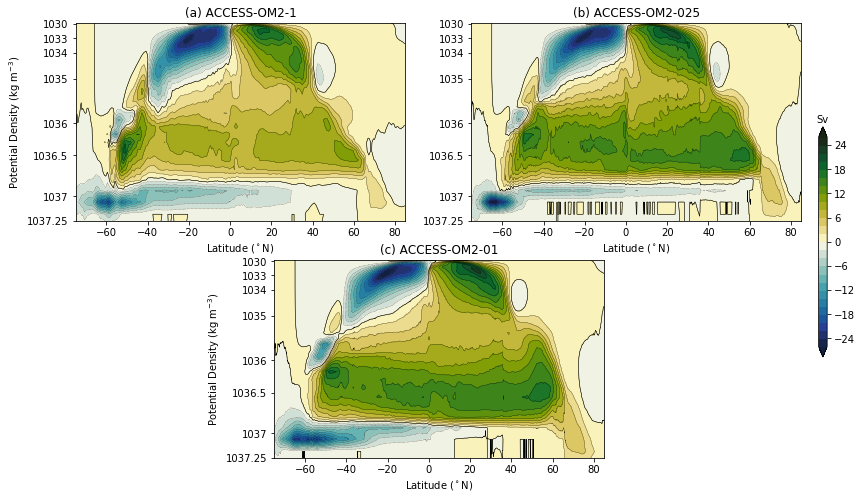

In [6]:
%%time
plt.figure(figsize=(12,8))
clev=np.arange(-26,26.01,2)

labels=['(a) ', '(b) ', '(c) ']
for i, ekey in enumerate(exptdata.exptdict.keys()):
    desc = exptdata.exptdict[ekey]['desc']
    ax = plt.subplot(2,2,i+1)
    psi_avg = calc_psi_avg(ekey)
    p1=plot_psi(psi_avg,clev)
    plt.title(labels[i]+desc)
    if (i==1):
        plt.ylabel('')

plt.subplots_adjust(left=0.08,right=0.92)
tmp = ax.get_position(original=True)
tmp.x0 = tmp.x0 + 0.23
tmp.x1 = tmp.x1 + 0.23
print(tmp)
ax.set_position(tmp)

ax1 = plt.axes([0.94,0.3,0.01,0.4])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Sv')

savefigure('mean_overturning')

### Now compute timeseries overturning cells

1deg_jra55v13_iaf_spinup1_B1
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


025deg_jra55v13_iaf_gmredi6
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
01deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
1deg_jra55v13_iaf_spinup1_B1
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
025deg_jra55v13_iaf_gmredi6
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
01deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 1min 7s, sys: 4min 5s, total: 5min 13s
Wall time: 14min 26s


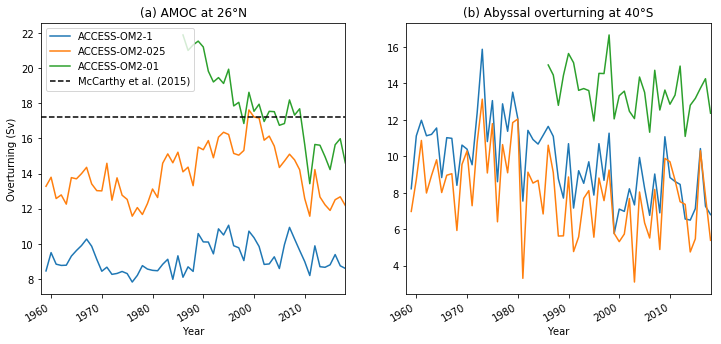

In [7]:
%%time
plt.figure(figsize=(12,5))
plt.subplot(122)
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    print(expt)
    
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                            chunks={'potrho': None},n=n_files,
                            time_units = time_units, offset=offset)
    psi = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
    psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                            chunks={'potrho': None},n=n_files,
                            time_units = time_units, offset=offset)
        psiGM = psiGM.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
        psi_sum = psi_sum + psiGM

    psi_aabw = -psi_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
    psi_aabw.plot(label=exptdata.exptdict[ekey]['desc'])
    
plt.gca().autoscale()
plt.ylabel('')
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.xlabel('Year')
plt.title('(b) Abyssal overturning at 40°S')

plt.subplot(121)
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    print(expt)
    
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},n=n_files,
                          time_units = time_units, offset=offset)
    psi = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None},n=n_files,
                            time_units = time_units, offset=offset)
        psiGM = psiGM.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_sum = psi_sum + psiGM

    psi_amoc = psi_sum.sel(potrho=slice(1035.5,None))\
                .max('potrho').resample(time='A').mean('time')
    psi_amoc.plot(label=exptdata.exptdict[ekey]['desc'])

# From McCarthy et al. (2015):
# The AMOC has a strength of 17.2 Sv ... over the 8.5 years from April 2004 to October 2012
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[17.2, 17.2],'k--',label="McCarthy et al. (2015)")

plt.gca().autoscale()
plt.legend()
plt.xlabel('Year')
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.ylabel('Overturning (Sv)')
plt.title('(a) AMOC at 26°N')

savefigure('overturning_timeseries')

In [ ]:
# testing remapping onto depth coords - NOT THERE YET!

ekey='1deg'

expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
    
## Load overturning from ocean.nc file
psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=n_files,
                          time_units=time_units, offset=offset)
psi = psi.sel(time=slice(pd.datetime(2008,1,1),None)).mean('time').sum('grid_xt_ocean')*1.0e-9
    
## If GM overturning is output, load that too
varlist = cc.get_variables(expt, 'ocean.nc')
if 'ty_trans_rho_gm' in varlist:
    GM = True
    psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=n_files,
                              time_units=time_units, offset=offset)
    psiGM = psiGM.sel(time=slice(pd.datetime(2008,1,1),None)).mean('time').sum('grid_xt_ocean')*1.0e-9
else:
    GM = False
        
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
if GM:
    psi_avg = psi_avg + psiGM
    
## This function basically splits the calculation up to save on memory:
psi_avg = cc.compute_by_block(psi_avg)


In [ ]:
plt.figure(figsize=(6,4))
clev=np.arange(-26,26.01,2)

p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()
    
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])

In [ ]:
pot_rho_2 = cc.get_nc_variable(expt, 'ocean.nc', 'pot_rho_2',
                          n=n_files,time_units=time_units, offset=offset)
pot_rho_2 = pot_rho_2.sel(time=slice(pd.datetime(2008,1,1),None)).mean('time').mean('xt_ocean')
pot_rho_2

In [ ]:
potrho_edges = cc.get_nc_variable(expt, 'ocean.nc', 'potrho_edges',n=-1).values
potrho_edges

In [ ]:
p1=pot_rho_2.plot.contour(levels=potrho_edges,yincrease=False)

In [ ]:
pot_rho_2.plot(yincrease=False)

In [ ]:
psi_avg.potrho


In [ ]:
pr2 = pot_rho_2.isel(yt_ocean=140).dropna('st_ocean')
pr2

zz = xr.DataArray(pr2.st_ocean.values,[('pr2',pr2.values)])
zz

In [ ]:
zz.pr2

In [ ]:
zz2 = zz.interp(pr2 = psi_avg.potrho)
zz2

In [ ]:
zz.plot(yincrease=False,linestyle='-',marker='o')
zz2.plot(yincrease=False,linestyle='-',marker='.')

In [ ]:
## need to make a matrix which has dimensions pot_rho_2, and values of isopycnal height.
(nrho, ny) = psi_avg.shape
tmp = np.empty([nrho,ny])
tmp[:] = np.nan
zz = xr.DataArray(tmp,[('potrho',psi_avg.potrho.values),('yt_ocean',pot_rho_2.yt_ocean.values)])
## That is, h(potrho,grid_yu_ocean) 
## note that this array is actually half a gridpoint off psi_avg ... oh well.
## also need to make a matrix for latitude.

for i in range(ny):
    pr2 = pot_rho_2.isel(yt_ocean=i).dropna('st_ocean')
    (jj,) = pr2.shape
    if jj>0:
        
        ## note fudges to make sure this variable is monotonic!!
        prdim = pr2.sortby(pr2).values 
        tmp = np.where(np.diff(prdim)==0.0)[0]
        for kk in range(tmp.shape[0]):
            print(i, jj, kk)
            prdim[tmp[kk]+1]=prdim[tmp[kk]] + 0.0001
            if (tmp[kk]<jj-2):
                if (prdim[tmp[kk]+2]==prdim[tmp[kk]+1]):
                    prdim[tmp[kk]+2]=prdim[tmp[kk]+1] + 0.0001
            
        ztmp = xr.DataArray(pr2.st_ocean.values,[('pr2',prdim)]) 
        ztmp2 = ztmp.interp(pr2 = psi_avg.potrho.values)
        zz[:,i] = ztmp2    ## There is a better way to do this??

In [ ]:
# This is how it looks. 
zz.plot()

# It's the right sort of thing .. but we need to make it go full depth and I think data is not well conditioned.

In [ ]:
## make y axis
yy = xr.DataArray(np.empty([nrho,ny]),[('potrho',psi_avg.potrho.values),('yt_ocean',pot_rho_2.yt_ocean.values)])
for i in range(80):
    yy[i,:] = pot_rho_2.yt_ocean.values
yy.plot()


In [ ]:
zz

In [ ]:
pr2.sortby(pr2).values

In [ ]:
prdim = pr2.sortby(pr2).values ## note fudges to make sure it is monotonic!!
tmp = np.where(np.diff(prdim)==0)[0][0]+1
prdim[tmp]=prdim[tmp] + 0.0001

In [ ]:
pot_rho_2.plot(vmin=1037.05,vmax=1037.2)